In [1]:
%pip install paddlepaddle-gpu -q
%pip install paddleocr -q
%pip install --quiet vietocr
%pip install paddlepaddle -q
#%pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.9/758.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.7/465.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [17]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from paddleocr import PaddleOCR

import torch

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

from paddleocr import PaddleOCR, draw_ocr


import difflib
import re
import math
import copy

# Paddle + VietOCR

In [4]:
config = Cfg.load_config_from_name('vgg_seq2seq')

In [5]:
#config['weights'] = './weights/transformerocr.pth'
#config['cnn']['pretrained']=False

config['weights'] = 'https://vocr.vn/data/vietocr/vgg_seq2seq.pth'
config['pretrain'] = 'https://vocr.vn/data/vietocr/vgg_seq2seq.pth'

detector = Predictor(config)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:03<00:00, 145MB/s]
10935it [00:10, 1093.17it/s]


In [6]:
config

{'vocab': 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
 'device': 'cuda:0',
 'seq_modeling': 'seq2seq',
 'transformer': {'encoder_hidden': 256,
  'decoder_hidden': 256,
  'img_channel': 256,
  'decoder_embedded': 256,
  'dropout': 0.1},
 'optimizer': {'max_lr': 0.001, 'pct_start': 0.1},
 'trainer': {'batch_size': 32,
  'print_every': 200,
  'valid_every': 4000,
  'iters': 100000,
  'export': './weights/transformerocr.pth',
  'checkpoint': './checkpoint/transformerocr_checkpoint.pth',
  'log': './train.log',
  'metrics': None},
 'dataset': {'name': 'data',
  'data_root': './img/',
  'train_annotation': 'annotation_train.txt',
  'valid_annotation': 'annotation_val_small.txt',
  'image_height': 32,
  'image_min_width': 32,
  'image_max_width': 512},
 'dataloader': {'num_workers': 3, 'pin_memory': True}

In [7]:
def display_image_in_actual_size(im_data, dpi=600):
    #im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [8]:
!wget -O test.jpg https://media-cdn-v2.laodong.vn/Storage/NewsPortal/2022/7/7/1065050/De2.jpg

--2024-03-19 08:05:54--  https://media-cdn-v2.laodong.vn/Storage/NewsPortal/2022/7/7/1065050/De2.jpg
Resolving media-cdn-v2.laodong.vn (media-cdn-v2.laodong.vn)... 128.1.50.190, 156.59.55.29, 156.59.55.30, ...
Connecting to media-cdn-v2.laodong.vn (media-cdn-v2.laodong.vn)|128.1.50.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344746 (337K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 336.67K   576KB/s    in 0.6s    

2024-03-19 08:05:56 (576 KB/s) - ‘test.jpg’ saved [344746/344746]



In [22]:
img_path = '/content/test.jpg'
img = cv2.imread(img_path)
#img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

paddle = PaddleOCR(use_angle_cls=False, lang="vi", use_gpu=True)
result = paddle.ocr(img_path, cls=False, det=True)#, rec=False)
result = result[:][:][0]

[2024/03/19 08:11:03] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_

mối quan hệ giữa nghệ thuật và cuộc sông.
chung thuy nhiều đa chống choi với sống gió giữa phá được mieu ta trong người thuy nha người thuy nghiệp the the the the trong th
thuy thi hiệu nhân tích đoạn trích trên: từ đó, liên hệ hinh ảnh trong quan trinh với nim an the trinh thuy
(Ngữ văn 12, Tập hai, NXB Giát Nam, 2020, 11)
Chiếc máy ảnh hiệu Pra-ti-ca.
cái đẹp tuyệt đinh của ngoại cảnh vừa mang lại.
theo thu thi thiến thiến thung nhấn tự cuốn nhim thu vào chiếc Pra-i - a ? cái khoanh khác tron người thu nhang nhưng nhưng nhưng
trong thi thi thi thu chon vệ dich vì nữa tôi gác máy lên bánh xâ tăng hóng băm " Tiên thanh m thu thuy nha nha nha nha nha nha n
sự toàn thiên, khám phá thấy cái khoảnh khắc trong ngân của tâm hôn
trong thu thu thi đon chính là đạo đir? Trong viân phút bối rối tôi tướng chính minh và thay cai chom ti cha thu tri thu trinh
thiến thi thi thi thi tri vớn hải rối trong trái tim như có cái gi bó lan đầu đa phát nien ra oun the trinh thu trinh
theo blana cảnh tù đườn

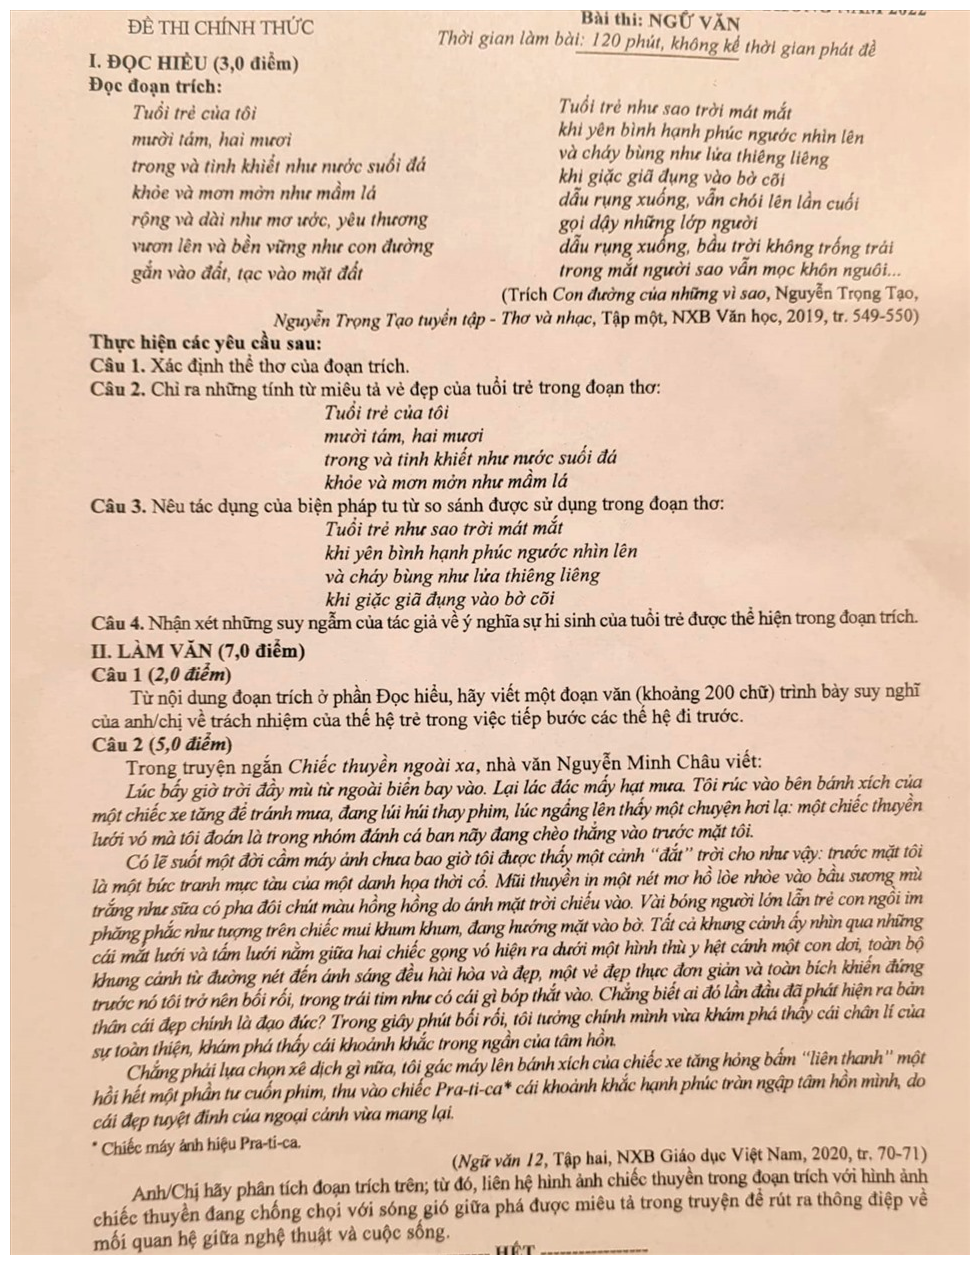

In [25]:
# Create Boxes
boxes = []
for line in result:
  line = line[0]
  boxes.append([[int(line[0][0]), int(line[0][1])], [int(line[2][0]), int(line[2][1])]])

boxes = boxes[::-1]

EXPEND = 5
for box in boxes:
  box[0][0] = box[0][0] - EXPEND
  box[0][1] = box[0][1] - EXPEND
  box[1][0] = box[1][0] + EXPEND
  box[1][1] = box[1][1] + EXPEND


texts = []
for box in boxes:
  cropped_image = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]

  try:
    cropped_image = Image.fromarray(cropped_image)
  except:
    continue

  #rec_result = Paddle.ocr(cropped_image, cls=True, det=False, rec=True)
  rec_result = detector.predict(cropped_image)

  text = rec_result#[0]

  texts.append(text)
  print(text)

display_image_in_actual_size(img, 100)

### Display some extracted images

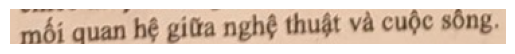

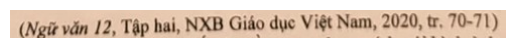

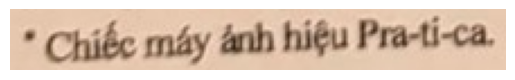

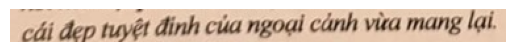

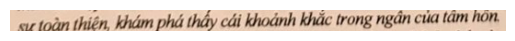

In [30]:
def process(image):
    plt.figure()
    plt.axis('off')
    plt.imshow(image)

count = 0
for box in boxes:
  cropped_image = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]
  try:
    process(cropped_image)
  except:
    pass
  count += 1
  if count == 10:
    break